## 5. Logistic Regression

#### Import all Libraries needed for the model 

In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels.api as sm
import pylab as pl

from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score

from sklearn.metrics import f1_score

from sklearn.metrics import roc_curve, auc

from sklearn import metrics

from sklearn.model_selection import train_test_split

### 5.1 Import the Open Food Dataset .

#### First import only 10000 records . We create the sample model using 10000 records and the read the entire dataset to create final model.

In [3]:
pd_1 = pd.read_csv('en.openfoodfacts.org.products.csv', sep='\t',nrows = 10000 )


/Users/vingadgil/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
pd_null = pd_1[pd_1.product_name.isnull()]
#pd_null[['code','product_name','ingredients_text']].head()

In [5]:
# Total number of records in dataframe and number of records with no ingredients.

print(len(pd_1[pd_1.ingredients_text.isnull()]))
print(len(pd_1))

5546
10000


Select only records from data which actually have ingredients i.e. ingredients_text has some values. We shall only be considering such records.

In [6]:
pd_1 = pd_1[pd_1.ingredients_text.notnull()]
len(pd_1)

4454

Out of 10000 records there are only 4454 records which has ingredients. For our sample , we only use 4454 records for modeling

Selecting only specific columns from the dataset which is required for the logisitic regresssion - Code, Product name,
Ingredients, Additives in the dataset and number of additives in each item.

In [7]:
pd_new = pd_1[['code' , 'product_name' , 'ingredients_text', 'additives','additives_n','main_category_en']]
pd_new = pd_new[pd_new.ingredients_text.notnull()]


### 5.2 Calculate Top 50 Ingredients from the Ingredients_text used across all food items

Split all the ingredients_text by comma ','

In [8]:
# Calculate top 50 Ingredients -

# get counts by ingredient
# taken from http://stackoverflow.com/questions/12680754/split-pandas-dataframe-string-entry-to-separate-rows
df_ingredients_tmp = pd_new[['code' , 'ingredients_text']]

df_ingredients = df_ingredients_tmp.ingredients_text.str.split(',').tolist()
df_tmp = pd.DataFrame(df_ingredients,index=df_ingredients_tmp.code).stack() 
df_tmp = df_tmp.reset_index()[[0, 'code']] # var1 variable is currently labeled 0
df_tmp.columns = ['ingredients_text', 'code'] # renaming var1

# Get the count for each ingredients.
df1 = df_tmp['ingredients_text'].str.upper().value_counts()
df1.index


Index([' SEL', ' SALT', ' SUCRE', ' SUGAR', ' EAU', ' WATER', ' DEXTROSE',
       ' NIACIN', ' CITRIC ACID', ' SIROP DE GLUCOSE',
       ...
       ' GROUND ROASTED _PEANUTS_', ' MATIÈRE GRASSE DE _LAIT_ ANHYDRE',
       'PIMENT ROUGE FORT', ' BIENENWACHS', 'ORANGE FILLING (GLUCOSE SYRUP',
       ' 9% TOMATEN', ' MALTO D'ORZO)', ' FLOUR IMPROVER: ASCORBIC ACID.  ',
       'ZARTBITTER SCHOKOLADE (KAKAOMASSE', 'ESSENCE NATURELLE'],
      dtype='object', length=17793)

In [9]:
df_tmp['ingredients_text'] = df_tmp['ingredients_text'].str.upper()

# group by each ingredient and count unique number of products ('code')
df_ingredients_ranks = pd.DataFrame(df_tmp.groupby('ingredients_text').code.nunique())
# rename col
df_ingredients_ranks.columns = ['num_products'] # renaming
# sort it
df_ingredients_ranks = df_ingredients_ranks.sort(['num_products'], ascending=[False])
# here is the top 50 ingredients
df_ingredients_top50 = df_ingredients_ranks.head(50)
df_ingredients_top50

/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,num_products
ingredients_text,
SEL,701
SALT,658
SUCRE,590
SUGAR,462
EAU,429
WATER,280
DEXTROSE,264
NIACIN,183
CITRIC ACID,169


### 5.3 Preparing data for  Logistic Regression Model 

Plotting Additives_N field. In order to plot the additives , we have ignored all entries which are 0. Just plotting values which are above 0.

In [10]:
pd_additive = pd_new[pd_new.additives_n > 0]

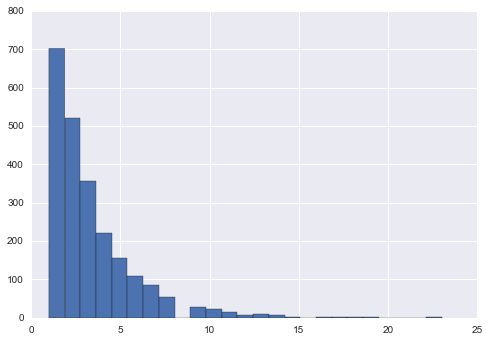

In [11]:
pd_additive.additives_n.hist(bins=25)

Since We would be using Additives_n column for Regression model we shall create a new column called'High Add' .


If Additives_n > 4 ,
     
   High Add = 1.
 
Else 

   High Add = 0.

In [12]:
pd_new['high_add'] = np.where(pd_new['additives_n']>4, '1', '0')

In [13]:
len(pd_new[pd_new['high_add'] == '1'])

505

Around 505 items out of 4454 records have more than 4 additives in ingredients. Around 12% records have high additives

##### Based on the Top 20 ingredients and checking the Top 20 Additives on Web , we create new dummy variables.

TOP 15 Additives 

1. DEXTROSE
2. CITRIC ACID
3. COCOA BUTTER
4. GLUCOSE
5. CORN SYRUP
6.  CARBONATED WATER
7. PALM OIL
8. MONOSODIUM GLUTAMATE
9. HYDROGENATED OIL
10. ARTIFICIAL COLORS
11. SODIUM NITRATE / SODIUM NITRITE
12. BHA
13. BHT
14. CORN STARCH
15. ARTIFICAL SWEETNERS- Saccharin,Aspartame,Sucralose,Agave nectar,Bleached starch



In [14]:
pd_new['ingredients_text'] = pd_new['ingredients_text'].str.upper()

In [18]:
def new_coumn(column_name,label):
    
    pattern = '|'.join(label)
    
    pd_new[column_name] = pd_new['ingredients_text'].str.contains(pattern)
    pd_new.column_name = pd_new.column_name.astype(int)
    
    return pd_new[column_name]

### 5.3.2 - Create dummy variables for Ingredients and Categories

In [15]:
# Check if Ingredients have Wheat .

#pd_new['has_wheat'] = pd_new['ingredients_text'].str.match('Wheat|wheat',case = '1', na='0')

wheat = ['Wheat','wheat','Weizen','blé','trigo','WHEAT']
pattern = '|'.join(wheat)
pd_new['has_wheat'] = pd_new['ingredients_text'].str.contains(pattern)
pd_new.has_wheat = pd_new.has_wheat.astype(int)


# Check if Ingredients has Salt.

salt = ['Salt','SALT','SAL','SALZ','SEL']
pattern = '|'.join(salt)
pd_new['has_salt'] = pd_new['ingredients_text'].str.contains(pattern) 
pd_new.has_salt = pd_new.has_salt.astype(int)

# Check if Ingredients has Sugar

sugar = ['SUGAR','SUCRE','AZÚCAR','ZUCKER','Sugar']
sugar = '|'.join(sugar)
pd_new['has_sugar'] = pd_new['ingredients_text'].str.contains(sugar)
pd_new.has_sugar = pd_new.has_sugar.astype(int)

# Check if Ingredients has Chocolate .

chocolate = ['CHOCO','CHOCOLATE','CHOCOLAT','SCHOKOLADE','Chocolate']
chocolate = '|'.join(chocolate)
pd_new['has_choco'] = pd_new['ingredients_text'].str.contains(chocolate)
pd_new.has_choco = pd_new.has_choco.astype(int)

# Check if Ingredients has Milk

milk = ['MILK','LECHE','MILCHE','LAIT','Milk']
milk = '|'.join(milk)

pd_new['has_milk'] = pd_new['ingredients_text'].str.contains(milk)
pd_new.has_milk = pd_new.has_milk.astype(int)

# Check if Ingredients has Color

color = ['Color','COLOR','FARBE','COULEUR']
color = '|'.join(color)

pd_new['has_color'] = pd_new['ingredients_text'].str.contains(color)
pd_new.has_color = pd_new.has_color.astype(int)

# Check if Ingredients has MSG

msg = ['MSG','Msg','MONOSODIUM GLUTAMATE']
msg = '|'.join(msg)

pd_new['has_msg'] = pd_new['ingredients_text'].str.contains(msg)
pd_new.has_msg = pd_new.has_msg.astype(int)

# Check if Ingredients has YEAST

yeast = ['Yeast','YEAST','LEVURE','HEFE','LEVADURA']
yeast = '|'.join(yeast)

pd_new['has_yeast'] = pd_new['ingredients_text'].str.contains(yeast)
pd_new.has_yeast = pd_new.has_yeast.astype(int)

# Check if Ingredients has cocoa butter

cocoa = ['Cocoa Butter','COCOA BUTTER','COCOA','KAKAOBUTTER','LE BEURRE DE CACAO','CACAO','KAKAO']
cocoa = '|'.join(cocoa)

pd_new['has_cocoa'] = pd_new['ingredients_text'].str.contains(cocoa)
pd_new.has_cocoa = pd_new.has_cocoa.astype(int)

# Check if Ingredients has Palm Oil

palm = ['Palm Oil','PALM OIL','PALMÖL','HUILE DE PALME','ACEITE DE PALMA']
palm = '|'.join(palm)

pd_new['has_palm'] = pd_new['ingredients_text'].str.contains(palm)
pd_new.has_palm = pd_new.has_palm.astype(int)
    


In [16]:
# Additional Columns
# Check if Ingredients has Water

water = ['WATER','water','WASSER','AGUA','EAU']
water = '|'.join(water)

pd_new['has_water'] = pd_new['ingredients_text'].str.contains(water)
pd_new.has_water = pd_new.has_water.astype(int)

# Check if Ingredients has Garlic

garlic = ['Garlic','GARLIC','AIL','KNOBLAUCH','AJO']
garlic = '|'.join(garlic)

pd_new['has_garlic'] = pd_new['ingredients_text'].str.contains(garlic)
pd_new.has_garlic = pd_new.has_garlic.astype(int)

# Check if Ingredients has Flour

flour = ['Flour','FLOUR','MEHL','FARINE','HARINA']
flour = '|'.join(flour)

pd_new['has_flour'] = pd_new['ingredients_text'].str.contains(flour)
pd_new.has_flour = pd_new.has_flour.astype(int)

# Check if Ingredients has Ginger

ginger = ['Ginger','GINGER','GINGREMBRE','INGWER','JINGIBRE']
ginger = '|'.join(ginger)

pd_new['has_ginger'] = pd_new['ingredients_text'].str.contains(ginger)
pd_new.has_ginger = pd_new.has_ginger.astype(int)

# Check if Ingredients has honey

honey = ['Honey','HONEY','HONIG','MIEL']
honey = '|'.join(honey)

pd_new['has_honey'] = pd_new['ingredients_text'].str.contains(honey)
pd_new.has_honey = pd_new.has_honey.astype(int)

In [17]:
pd_new.head()

,code,product_name,ingredients_text,additives,additives_n,main_category_en,high_add,has_wheat,has_salt,has_sugar,...,has_color,has_msg,has_yeast,has_cocoa,has_palm,has_water,has_garlic,has_flour,has_ginger,has_honey
5,0000000056434,diet lemonade by Sainsbury's,"CARBONATED WATER, ACID: CITRIC ACID; FLAVOURI...",[ carbonated-water -> en:carbonated-water ] ...,4.0,NaN,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6,0000001071894,Flute,WHEAT,[ wheat -> en:wheat ],0.0,Plant-based foods and beverages,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0000001471762,still Scottish water,WATER,[ water -> en:water ],0.0,NaN,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8,0000001798180,Fairtrade Ground Cinnamon,CINNAMON,[ cinnamon -> en:cinnamon ],0.0,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0000005200016,lentilles vertes,LENTILLES VERTES,[ lentilles-vertes -> fr:lentilles-vertes ] ...,0.0,Plant-based foods and beverages,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Create Dummy Variables for each of the Categories. The Top 20 Categories are -

Plant-based foods and beverages                     
Sugary snacks                                        
Beverages                                            
Dairies                                              
Groceries                                            
Meats                                                
Fresh foods                                          
Meals                                                
Salty snacks                                         
Canned foods                                         
Frozen foods                                         
Fruit juices                                         
Breakfasts                                            
Seafood                                               
Desserts                                              
          

### Create Additional Dummy Columns in dataframe for TOP 20 CATEGORIES

In [58]:
# Create columns on Categories 
pd_new['is_plant'] =  np.where(pd_new['main_category_en'] == 'Plant-based foods and beverages', '1', '0')
pd_new.is_plant = pd_new.is_plant.astype(int)

pd_new['is_bev'] = np.where(pd_new['main_category_en'] == 'Beverages','1','0')
pd_new.is_bev = pd_new.is_bev.astype(int)

pd_new['is_sugar'] = np.where(pd_new['main_category_en'] == 'Sugary snacks','1','0')
pd_new.is_sugar = pd_new.is_sugar.astype(int)

pd_new['is_salt'] = np.where(pd_new['main_category_en'] == 'Salty snacks','1','0')
pd_new.is_salt = pd_new.is_salt.astype(int)

pd_new['is_dairy'] = np.where(pd_new['main_category_en'] == 'Dairies','1','0')
pd_new.is_dairy = pd_new.is_dairy.astype(int)

pd_new['is_meat'] = np.where(pd_new['main_category_en'] == 'Meats|Seafood','1','0')
pd_new.is_meat = pd_new.is_meat.astype(int)

pd_new['is_fresh'] = np.where(pd_new['main_category_en'] == 'Fresh foods','1','0')
pd_new.is_fresh = pd_new.is_fresh.astype(int)

pd_new['is_break'] = np.where(pd_new['main_category_en'] == 'Breakfasts','1','0')
pd_new.is_break = pd_new.is_break.astype(int)

pd_new['is_frozen'] = np.where(pd_new['main_category_en'] == 'Frozen foods','1','0')
pd_new.is_frozen = pd_new.is_frozen.astype(int)

pd_new['is_juices'] = np.where(pd_new['main_category_en'] == 'Fruit Juices','1','0')
pd_new.is_juices = pd_new.is_juices.astype(int)



In [19]:
# manually add the intercept
pd_new['intercept'] = 1.0

In [20]:
pd_new['high_add'] = pd_new['high_add'].astype(int)

In [21]:
pd_new['text_count'] = pd_new['ingredients_text'].apply(lambda x: x.count(',') + 1)

In [22]:
#pd_new.to_csv('abcd.csv')
pd_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4454 entries, 5 to 9999
Data columns (total 24 columns):
code                4454 non-null object
product_name        4417 non-null object
ingredients_text    4454 non-null object
additives           3987 non-null object
additives_n         4452 non-null float64
main_category_en    4192 non-null object
high_add            4454 non-null int64
has_wheat           4454 non-null int64
has_salt            4454 non-null int64
has_sugar           4454 non-null int64
has_choco           4454 non-null int64
has_milk            4454 non-null int64
has_color           4454 non-null int64
has_msg             4454 non-null int64
has_yeast           4454 non-null int64
has_cocoa           4454 non-null int64
has_palm            4454 non-null int64
has_water           4454 non-null int64
has_garlic          4454 non-null int64
has_flour           4454 non-null int64
has_ginger          4454 non-null int64
has_honey           4454 non-null int64
interc

In [23]:
pd_new.head()

,code,product_name,ingredients_text,additives,additives_n,main_category_en,high_add,has_wheat,has_salt,has_sugar,...,has_yeast,has_cocoa,has_palm,has_water,has_garlic,has_flour,has_ginger,has_honey,intercept,text_count
5,0000000056434,diet lemonade by Sainsbury's,"CARBONATED WATER, ACID: CITRIC ACID; FLAVOURI...",[ carbonated-water -> en:carbonated-water ] ...,4.0,NaN,0,0,0,0,...,0,0,0,1,0,0,0,0,1.0,3
6,0000001071894,Flute,WHEAT,[ wheat -> en:wheat ],0.0,Plant-based foods and beverages,0,1,0,0,...,0,0,0,0,0,0,0,0,1.0,1
7,0000001471762,still Scottish water,WATER,[ water -> en:water ],0.0,NaN,0,0,0,0,...,0,0,0,1,0,0,0,0,1.0,1
8,0000001798180,Fairtrade Ground Cinnamon,CINNAMON,[ cinnamon -> en:cinnamon ],0.0,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,1
9,0000005200016,lentilles vertes,LENTILLES VERTES,[ lentilles-vertes -> fr:lentilles-vertes ] ...,0.0,Plant-based foods and beverages,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,1


In [25]:
pd_new[['ingredients_text','text_count']].head(10)

,ingredients_text,text_count
5,"CARBONATED WATER, ACID: CITRIC ACID; FLAVOURI...",3
6,WHEAT,1
7,WATER,1
8,CINNAMON,1
9,LENTILLES VERTES,1
11,"SUCRE, FARINE DE _BLÉ_, GRAISSE ET HUILES VÉGÉ...",15
12,"THÉ NOIR DE CHINE, ZESTES D'ORANGES 7,5 %, ARÔ...",9
13,"SIROP SAVEUR PISTACHE 5 CL : SIROP 99,16 % (SU...",39
14,ตีนไก่,1
16,77,1


### 5.4 LOGISTIC REGRESSION MODEL

### 5.4.1  - Baseline Model

In [26]:
# Creating the model with 7 dependant columns

train_cols = [ 'has_wheat' , 'has_salt' , 'has_sugar', 'has_choco' ,'has_milk','has_cocoa','has_palm','intercept']
#               'has_water', 'has_garlic','has_flour' ,'has_ginger','has_honey',

logit = sm.Logit(pd_new['high_add'], pd_new[train_cols])

# fit the model
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.306835
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               high_add   No. Observations:                 4454
Model:                          Logit   Df Residuals:                     4446
Method:                           MLE   Df Model:                            7
Date:                Wed, 30 Nov 2016   Pseudo R-squ.:                  0.1321
Time:                        15:31:09   Log-Likelihood:                -1366.6
converged:                       True   LL-Null:                       -1574.6
                                        LLR p-value:                 9.131e-86
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
has_wheat      0.7141      0.143      5.005      0.000         0.434     0.994
has_salt       0.8491      0.118      7.204      0.000         0.618     1.080
has_sugar      0.7972      0.112      7.092      0.000         0.577     1.018
has_choco      0.4492      0.251      1.792      0.073        -0.042     0.941
has_milk       0.8521      0.107      7.935      0.000         0.642     1.063
has_cocoa     -0.5877      0.222     -2.652      0.008        -1.022    -0.153
has_palm       0.8585      0.167      5.131      0.000         0.531     1.186
intercept     -3.4025      0.111    -30.642      0.000        -3.620    -3.185
==============================================================================
"""

In [33]:
# Find the actual values of ones and zeros in each dummy column
#print(pd_new.has_wheat.sum())
#print(pd_new.has_salt.sum())
#print(pd_new.has_palm.sum())
#print(pd_new.has_sugar.sum())
#print(pd_new.has_cocoa.sum())
#print(pd_new.has_milk.sum())
#print(pd_new.has_color.sum())

In [27]:
# look at the confidence interval of each coeffecient
result.conf_int()

,0,1
has_wheat,0.434454,0.993810
has_salt,0.618117,1.080173
has_sugar,0.576910,1.017536
has_choco,-0.042165,0.940580
has_milk,0.641628,1.062586
has_cocoa,-1.021989,-0.153354
has_palm,0.530542,1.186377
intercept,-3.620184,-3.184909


###### Odds Ratio

In [28]:
np.exp(result.params)

has_wheat    2.042413
has_salt     2.337647
has_sugar    2.219369
has_choco    1.567070
has_milk     2.344581
has_cocoa    0.555620
has_palm     2.359524
intercept    0.033288
dtype: float64

In [30]:
params = result.params

conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print (np.exp(conf))

               2.5%     97.5%        OR
has_wheat  1.544120  2.701508  2.042413
has_salt   1.855430  2.945190  2.337647
has_sugar  1.780528  2.766370  2.219369
has_choco  0.958712  2.561468  1.567070
has_milk   1.899571  2.893844  2.344581
has_cocoa  0.359879  0.857826  0.555620
has_palm   1.699854  3.275195  2.359524
intercept  0.026778  0.041382  0.033288


In [31]:
# Predict Y column using the logit function.
pd_new['ypred'] = result.predict(pd_new[train_cols])


In [32]:
pd_new[['high_add','ypred']].head()

,high_add,ypred
5,0,0.032216
6,0,0.063660
7,0,0.032216
8,0,0.032216
9,0,0.032216


Converting the ypred probability into value of 0 and 1

In [33]:
pd_new['ypred_class'] = np.where(pd_new['ypred']>0.12, '1', '0')
pd_new['ypred_class'] = pd_new['ypred_class'].astype(int)


In [34]:
# Create confusin matrix from Scikit
matrix = confusion_matrix(pd_new['high_add'], pd_new['ypred_class'])
print(matrix)


[[2699 1250]
 [ 144  361]]


In [35]:
# Using Pandas confusion create the confusion matrix

from pandas_confusion import ConfusionMatrix

confusion_matrix = ConfusionMatrix(pd_new['high_add'], pd_new['ypred_class'])
print("Confusion matrix:\n%s" % confusion_matrix)

Confusion matrix:
Predicted     0     1  __all__
Actual                        
0          2699  1250     3949
1           144   361      505
__all__    2843  1611     4454


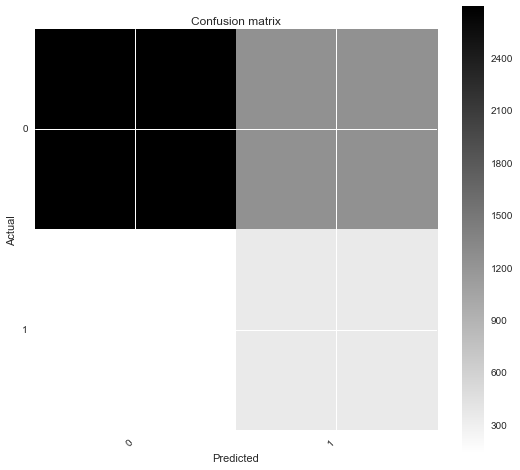

In [36]:
confusion_matrix.plot()
plt.show()

Statistics of the Model

In [38]:
confusion_matrix.print_stats()

Confusion Matrix:

Predicted     0     1  __all__
Actual                        
0          2699  1250     3949
1           144   361      505
__all__    2843  1611     4454


Overall Statistics:

Accuracy: 0.687022900763
95% CI: (0.67317322857085415, 0.70062694192579322)
No Information Rate: ToDo
P-Value [Acc > NIR]: 4.45220001629e-12
Kappa: 0.203740557616
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                        0          1
Population                                  4454       4454
P: Condition positive                       3949        505
N: Condition negative                        505       3949
Test outcome positive                       2843       1611
Test outcome negative                       1611       2843
TP: True Positive                           2699        361
TN: True Negative                            361       2699
FP: False Positive                           144       1250
FN: False Negative                          1250  

In [45]:
# Another way of calculating accuracy score
#X.mean()
#Ypred = (result.predict(pd_new[train_cols]) >= 0.12)
#true_pos = Ypred * X
#true_neg = (1 - Ypred) * (1 - X)
#acc = (sum(true_pos) + sum(true_neg))/len(X)
#acc

In [39]:
# Create ROC curve for Baseline model
false_positive_rate, true_positive_rate, thresholds = roc_curve(pd_new['high_add'], pd_new['ypred'])
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc


0.75054268658063572

Overall Accuracy of the Model above is around 68% which is a good, so these predictor variables do have some
influence on high additives.

Model was able to predict around 2699 true positives out of 4454 records which is a good sign

### 5.4.2 Random Model created using Random Values for predictor variables

In [40]:
#New model - Create a new dataframe with random values in 7 columns and cross check with above logit model

pd_random = pd_new[['code','product_name','high_add']]
pd_size = len(pd_random)

pd_random['col1'] = np.random.randint(2, size=pd_size)
pd_random['col2'] = np.random.randint(2, size=pd_size)
pd_random['col3'] = np.random.randint(2, size=pd_size)
pd_random['col4'] = np.random.randint(2, size=pd_size)
pd_random['col5'] = np.random.randint(2, size=pd_size)
pd_random['col6'] = np.random.randint(2, size=pd_size)
pd_random['col7'] = np.random.randint(2, size=pd_size)


/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

In [41]:
pd_random['intercept'] = 1.0
pd_random.head()

/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,code,product_name,high_add,col1,col2,col3,col4,col5,col6,col7,intercept
5,0000000056434,diet lemonade by Sainsbury's,0,1,0,1,1,0,1,0,1.0
6,0000001071894,Flute,0,1,0,0,0,1,1,1,1.0
7,0000001471762,still Scottish water,0,1,0,1,1,1,1,0,1.0
8,0000001798180,Fairtrade Ground Cinnamon,0,0,1,0,1,1,0,0,1.0
9,0000005200016,lentilles vertes,0,1,0,1,1,0,0,0,1.0


In [42]:
train_cols_r = [ 'col1' , 'col2' , 'col3', 'col4' ,'col5','col6','col7','intercept']
logit_random = sm.Logit(pd_random['high_add'], pd_random[train_cols_r])

# fit the model
result_random = logit_random.fit()
result_random.summary()

Optimization terminated successfully.
         Current function value: 0.352601
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               high_add   No. Observations:                 4454
Model:                          Logit   Df Residuals:                     4446
Method:                           MLE   Df Model:                            7
Date:                Wed, 30 Nov 2016   Pseudo R-squ.:                0.002620
Time:                        15:42:56   Log-Likelihood:                -1570.5
converged:                       True   LL-Null:                       -1574.6
                                        LLR p-value:                    0.3111
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
col1          -0.0058      0.095     -0.062      0.951        -0.191     0.180
col2          -0.0956      0.095     -1.009      0.313        -0.281     0.090
col3          -0.0093      0.095     -0.098      0.922        -0.195     0.176
col4           0.2290      0.095      2.413      0.016         0.043     0.415
col5           0.0886      0.095      0.936      0.349        -0.097     0.274
col6           0.0223      0.095      0.235      0.814        -0.163     0.208
col7           0.0581      0.095      0.613      0.540        -0.128     0.244
intercept     -2.2057      0.134    -16.431      0.000        -2.469    -1.943
==============================================================================
"""

In [43]:
# Predict Y using the logit function.
pd_random['ypred'] = result.predict(pd_random[train_cols_r])

/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [44]:
pd_random['ypred_class'] = np.where(pd_random['ypred']>0.12, '1', '0')
pd_random['ypred_class'] = pd_random['ypred_class'].astype(int)

/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [45]:
from pandas_confusion import ConfusionMatrix

matrix_random = ConfusionMatrix(pd_random['high_add'], pd_random['ypred_class'])
print("Confusion matrix:\n%s" % matrix_random)


Confusion matrix:
Predicted     0     1  __all__
Actual                        
0          1077  2872     3949
1           134   371      505
__all__    1211  3243     4454


In [46]:
#matrix_random.plot()
#plt.show()

In [47]:
# Calculate the accuracy score
matrix_random.print_stats()

Confusion Matrix:

Predicted     0     1  __all__
Actual                        
0          1077  2872     3949
1           134   371      505
__all__    1211  3243     4454


Overall Statistics:

Accuracy: 0.32510103278
95% CI: (0.31135084992857232, 0.33908089865326074)
No Information Rate: ToDo
P-Value [Acc > NIR]: 1.0
Kappa: 0.00219389212919
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                         0           1
Population                                   4454        4454
P: Condition positive                        3949         505
N: Condition negative                         505        3949
Test outcome positive                        1211        3243
Test outcome negative                        3243        1211
TP: True Positive                            1077         371
TN: True Negative                             371        1077
FP: False Positive                            134        2872
FN: False Negative                           

In [48]:
# ROC values for Random Model
false_positive_ran, true_positive_ran, thresholds_ran = roc_curve(pd_random['high_add'], pd_random['ypred'])
roc_auc_ran = auc(false_positive_ran, true_positive_ran)
roc_auc_ran

0.508748674310328

In [57]:
print(metrics.classification_report(pd_new['high_add'], pd_new['ypred_class']))

             precision    recall  f1-score   support

          0       0.95      0.68      0.79      3949
          1       0.22      0.71      0.34       505

avg / total       0.87      0.69      0.74      4454



Accuracy of the Random model is around 32% which is half that of that Baseline model. So Baseline Model looks better than random model, it has predicted more False Negatives. Model has predicted more Wrong values.


### 5.4.3 Model with 12 Dependant Variable

In [49]:
# 12 Ingredients variables

train_cols_12 = [ 'has_wheat' , 'has_salt' , 'has_sugar', 'has_choco' ,'has_milk','has_cocoa','has_palm',
               'has_water', 'has_garlic','has_flour' ,'has_ginger','has_honey','intercept']

logit_12 = sm.Logit(pd_new['high_add'], pd_new[train_cols_12])

# fit the model
result_12 = logit_12.fit()
result_12.summary()

Optimization terminated successfully.
         Current function value: 0.291784
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               high_add   No. Observations:                 4454
Model:                          Logit   Df Residuals:                     4441
Method:                           MLE   Df Model:                           12
Date:                Wed, 30 Nov 2016   Pseudo R-squ.:                  0.1746
Time:                        15:47:56   Log-Likelihood:                -1299.6
converged:                       True   LL-Null:                       -1574.6
                                        LLR p-value:                4.930e-110
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
has_wheat      0.5492      0.163      3.370      0.001         0.230     0.869
has_salt       0.4594      0.131      3.505      0.000         0.203     0.716
has_sugar      0.5677      0.118      4.818      0.000         0.337     0.799
has_choco      0.2472      0.262      0.945      0.345        -0.266     0.760
has_milk       0.8951      0.112      7.985      0.000         0.675     1.115
has_cocoa     -0.2960      0.234     -1.263      0.207        -0.756     0.163
has_palm       0.9538      0.178      5.365      0.000         0.605     1.302
has_water      1.0891      0.111      9.793      0.000         0.871     1.307
has_garlic    -0.2728      0.163     -1.671      0.095        -0.593     0.047
has_flour      0.6211      0.133      4.684      0.000         0.361     0.881
has_ginger    -0.0389      0.317     -0.123      0.902        -0.660     0.582
has_honey     -0.5302      0.310     -1.711      0.087        -1.138     0.077
intercept     -3.6988      0.122    -30.410      0.000        -3.937    -3.460
==============================================================================
"""

In [50]:
result_12.conf_int()

,0,1
has_wheat,0.229763,0.868601
has_salt,0.202514,0.716287
has_sugar,0.336761,0.798678
has_choco,-0.265737,0.760091
has_milk,0.675382,1.114768
has_cocoa,-0.755525,0.163443
has_palm,0.605317,1.302232
has_water,0.871106,1.307058
has_garlic,-0.592678,0.047123
has_flour,0.361219,0.880945


In [51]:
np.exp(result_12.params)

has_wheat     1.731836
has_salt      1.583124
has_sugar     1.764239
has_choco     1.280406
has_milk      2.447519
has_cocoa     0.743757
has_palm      2.595489
has_water     2.971545
has_garlic    0.761262
has_flour     1.860940
has_ginger    0.961875
has_honey     0.588464
intercept     0.024753
dtype: float64

In [52]:
# Predict Y using the logit function.
pd_new['ypred_12'] = result_12.predict(pd_new[train_cols_12])

pd_new['ypred_class_12'] = np.where(pd_new['ypred_12']>0.12, '1', '0')
pd_new['ypred_class_12'] = pd_new['ypred_class_12'].astype(int)


In [53]:
confusion_matrix_12 = ConfusionMatrix(pd_new['high_add'], pd_new['ypred_class_12'])
#print("Confusion matrix:\n%s" % confusion_matrix_12)

confusion_matrix_12.print_stats()

Confusion Matrix:

Predicted     0     1  __all__
Actual                        
0          3121   828     3949
1           168   337      505
__all__    3289  1165     4454


Overall Statistics:

Accuracy: 0.77638078132
95% CI: (0.76385270352273649, 0.78854542877754974)
No Information Rate: ToDo
P-Value [Acc > NIR]: 2.62514302925e-09
Kappa: 0.29151756839
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                        0          1
Population                                  4454       4454
P: Condition positive                       3949        505
N: Condition negative                        505       3949
Test outcome positive                       3289       1165
Test outcome negative                       1165       3289
TP: True Positive                           3121        337
TN: True Negative                            337       3121
FP: False Positive                           168        828
FN: False Negative                           828    

In [54]:
# Create ROC curve for 12 model
false_positive_rate_12, true_positive_rate_12, thresholds = roc_curve(pd_new['high_add'], pd_new['ypred_12'])
roc_auc_12 = auc(false_positive_rate_12, true_positive_rate_12)
roc_auc_12

0.79125333146127974

Accuracy of this Model is now 77% which is better than Baseline model. We are able to predict more True Positives 
in this model

### 5.4.4 Model with Ingredients and Categories

Create Logitistic Regression with Ingredients and Category Dependant Variable

In [60]:
train_cols_20 = [ 'has_wheat' , 'has_salt' , 'has_sugar', 'has_choco' ,'has_milk','has_cocoa','has_palm',
               'has_water', 'has_garlic','has_flour' ,'has_ginger','has_honey','is_plant','is_bev',
                 'is_sugar','is_salt','is_frozen','is_break','is_dairy','is_fresh','intercept']

#'is_frozen' ,'is_break' ,'is_dairy', 'is_fresh' ,'is_meat'

logit_20 = sm.Logit(pd_new['high_add'], pd_new[train_cols_20])

# fit the model
result_20 = logit_20.fit()
result_20.summary()

Optimization terminated successfully.
         Current function value: 0.287132
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               high_add   No. Observations:                 4454
Model:                          Logit   Df Residuals:                     4433
Method:                           MLE   Df Model:                           20
Date:                Wed, 30 Nov 2016   Pseudo R-squ.:                  0.1878
Time:                        15:52:24   Log-Likelihood:                -1278.9
converged:                       True   LL-Null:                       -1574.6
                                        LLR p-value:                1.825e-112
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
has_wheat      0.5827      0.168      3.464      0.001         0.253     0.912
has_salt       0.3723      0.141      2.634      0.008         0.095     0.649
has_sugar      0.4756      0.121      3.922      0.000         0.238     0.713
has_choco      0.1431      0.261      0.548      0.584        -0.369     0.655
has_milk       0.8027      0.120      6.687      0.000         0.567     1.038
has_cocoa     -0.5811      0.245     -2.375      0.018        -1.061    -0.102
has_palm       0.9487      0.181      5.243      0.000         0.594     1.303
has_water      1.1756      0.121      9.715      0.000         0.938     1.413
has_garlic    -0.1770      0.166     -1.069      0.285        -0.502     0.148
has_flour      0.6421      0.141      4.556      0.000         0.366     0.918
has_ginger    -0.2097      0.328     -0.640      0.522        -0.852     0.433
has_honey     -0.4887      0.314     -1.554      0.120        -1.105     0.128
is_plant      -0.7324      0.174     -4.203      0.000        -1.074    -0.391
is_bev        -0.2957      0.233     -1.272      0.204        -0.751     0.160
is_sugar       0.5346      0.180      2.975      0.003         0.182     0.887
is_salt       -0.0245      0.333     -0.074      0.941        -0.677     0.628
is_frozen     -0.8833      0.442     -1.999      0.046        -1.749    -0.017
is_break       0.3012      0.428      0.704      0.481        -0.537     1.139
is_dairy      -0.1105      0.238     -0.463      0.643        -0.578     0.357
is_fresh       0.0597      0.276      0.216      0.829        -0.481     0.600
intercept     -3.5088      0.144    -24.354      0.000        -3.791    -3.226
==============================================================================
"""

In [61]:
result_20.conf_int()

,0,1
has_wheat,0.253020,0.912417
has_salt,0.095318,0.649277
has_sugar,0.237938,0.713354
has_choco,-0.368682,0.654917
has_milk,0.567461,1.038025
has_cocoa,-1.060728,-0.101528
has_palm,0.594078,1.303353
has_water,0.938459,1.412801
has_garlic,-0.501608,0.147577
has_flour,0.365864,0.918319


In [62]:
np.exp(result_20.params)


has_wheat     1.790901
has_salt      1.451064
has_sugar     1.609053
has_choco     1.153865
has_milk      2.231654
has_cocoa     0.559267
has_palm      2.582391
has_water     3.240182
has_garlic    0.837767
has_flour     1.900451
has_ginger    0.810818
has_honey     0.613428
is_plant      0.480748
is_bev        0.744024
is_sugar      1.706830
is_salt       0.975789
is_frozen     0.413415
is_break      1.351443
is_dairy      0.895376
is_fresh      1.061469
intercept     0.029933
dtype: float64

In [63]:
# Predict Y using the logit function.
pd_new['ypred_20'] = result_20.predict(pd_new[train_cols_20])

pd_new['ypred_class_20'] = np.where(pd_new['ypred_20']>0.12, '1', '0')
pd_new['ypred_class_20'] = pd_new['ypred_class_20'].astype(int)

In [64]:
confusion_matrix_20 = ConfusionMatrix(pd_new['high_add'], pd_new['ypred_class_20'])
#print("Confusion matrix:\n%s" % confusion_matrix_20)

confusion_matrix_20.print_stats()

Confusion Matrix:

Predicted     0     1  __all__
Actual                        
0          2992   957     3949
1           141   364      505
__all__    3133  1321     4454


Overall Statistics:

Accuracy: 0.753480017961
95% CI: (0.74054692050475879, 0.76607993050642931)
No Information Rate: ToDo
P-Value [Acc > NIR]: 5.49273631902e-14
Kappa: 0.280682426913
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                        0          1
Population                                  4454       4454
P: Condition positive                       3949        505
N: Condition negative                        505       3949
Test outcome positive                       3133       1321
Test outcome negative                       1321       3133
TP: True Positive                           2992        364
TN: True Negative                            364       2992
FP: False Positive                           141        957
FN: False Negative                           957  

In [65]:
# Create ROC curve for  model with 20 dependant variables
false_positive_rate_20, true_positive_rate_20, thresholds = roc_curve(pd_new['high_add'], pd_new['ypred_20'])
roc_auc_20 = auc(false_positive_rate_20, true_positive_rate_20)
roc_auc_20

0.8082016001043002

Acurracy is around 75 % which is a good fit Model .

### 5.4.5 Model with Ingredients text , Categories and Ingredients Count

In [66]:
train_cols_21 = [ 'has_wheat' , 'has_salt' , 'has_sugar', 'has_choco' ,'has_milk','has_cocoa','has_palm',
               'has_water', 'has_garlic','has_flour' ,'has_ginger','has_honey','is_plant','is_bev',
                 'is_sugar','is_salt','is_frozen','is_break','is_dairy','is_fresh','text_count','intercept']

#'is_frozen' ,'is_break' ,'is_dairy', 'is_fresh' ,'is_meat'

logit_21 = sm.Logit(pd_new['high_add'], pd_new[train_cols_21])

# fit the model
result_21 = logit_21.fit()
result_21.summary()

Optimization terminated successfully.
         Current function value: 0.225210
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Actual   No. Observations:                 4454
Model:                          Logit   Df Residuals:                     4432
Method:                           MLE   Df Model:                           21
Date:                Wed, 30 Nov 2016   Pseudo R-squ.:                  0.3630
Time:                        15:57:23   Log-Likelihood:                -1003.1
converged:                       True   LL-Null:                       -1574.6
                                        LLR p-value:                8.604e-229
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
has_wheat     -0.1230      0.208     -0.591      0.555        -0.531     0.285
has_salt      -0.3441      0.165     -2.088      0.037        -0.667    -0.021
has_sugar     -0.1655      0.141     -1.170      0.242        -0.443     0.112
has_choco     -0.3075      0.310     -0.993      0.321        -0.914     0.299
has_milk      -0.0359      0.144     -0.250      0.803        -0.318     0.246
has_cocoa     -0.8572      0.280     -3.058      0.002        -1.407    -0.308
has_palm       0.7269      0.220      3.303      0.001         0.296     1.158
has_water      0.4987      0.142      3.522      0.000         0.221     0.776
has_garlic    -1.4341      0.221     -6.476      0.000        -1.868    -1.000
has_flour     -0.2043      0.171     -1.195      0.232        -0.539     0.131
has_ginger    -3.0551      0.480     -6.367      0.000        -3.996    -2.115
has_honey     -1.0698      0.368     -2.910      0.004        -1.790    -0.349
is_plant      -0.8157      0.207     -3.935      0.000        -1.222    -0.409
is_bev         0.0494      0.248      0.199      0.842        -0.437     0.536
is_sugar       0.9017      0.200      4.507      0.000         0.510     1.294
is_salt        0.2540      0.373      0.681      0.496        -0.477     0.985
is_frozen     -2.8317      0.653     -4.336      0.000        -4.112    -1.552
is_break       0.7859      0.503      1.564      0.118        -0.199     1.771
is_dairy       0.3131      0.259      1.210      0.226        -0.194     0.820
is_fresh      -1.1797      0.352     -3.351      0.001        -1.870    -0.490
text_count     0.1864      0.010     19.178      0.000         0.167     0.205
intercept     -4.1045      0.165    -24.814      0.000        -4.429    -3.780
==============================================================================
"""

In [68]:
result_21.conf_int()

,0,1
has_wheat,-0.530994,0.284951
has_salt,-0.667114,-0.021134
has_sugar,-0.442575,0.111647
has_choco,-0.914400,0.299356
has_milk,-0.317538,0.245795
has_cocoa,-1.406537,-0.307888
has_palm,0.295641,1.158246
has_water,0.221209,0.776165
has_garlic,-1.868192,-1.000085
has_flour,-0.539249,0.130704


In [69]:
np.exp(result_21.params)

has_wheat     0.884245
has_salt      0.708841
has_sugar     0.847500
has_choco     0.735267
has_milk      0.964764
has_cocoa     0.424343
has_palm      2.068749
has_water     1.646558
has_garlic    0.238320
has_flour     0.815240
has_ginger    0.047116
has_honey     0.343084
is_plant      0.442331
is_bev        1.050684
is_sugar      2.463678
is_salt       1.289191
is_frozen     0.058912
is_break      2.194466
is_dairy      1.367705
is_fresh      0.307366
text_count    1.204882
intercept     0.016498
dtype: float64

In [70]:
# Predict Y using the logit function.
pd_new['ypred_21'] = result_21.predict(pd_new[train_cols_21])

pd_new['ypred_class_21'] = np.where(pd_new['ypred_21']>0.12, '1', '0')
pd_new['ypred_class_21'] = pd_new['ypred_class_21'].astype(int)

In [71]:
confusion_matrix = ConfusionMatrix(pd_new['high_add'], pd_new['ypred_class_21'])
#print("Confusion matrix:\n%s" % confusion_matrix)

confusion_matrix.print_stats()



Confusion Matrix:

Predicted     0    1  __all__
Actual                       
0          3386  563     3949
1            88  417      505
__all__    3474  980     4454


Overall Statistics:

Accuracy: 0.853839245622
95% CI: (0.84312050288304907, 0.86409171022628684)
No Information Rate: ToDo
P-Value [Acc > NIR]: 6.82490526912e-36
Kappa: 0.484467826733
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                       0         1
Population                                 4454      4454
P: Condition positive                      3949       505
N: Condition negative                       505      3949
Test outcome positive                      3474       980
Test outcome negative                       980      3474
TP: True Positive                          3386       417
TN: True Negative                           417      3386
FP: False Positive                           88       563
FN: False Negative                          563        88
TPR: (Sensitivi

In [72]:

# Create ROC curve for Baseline model
false_positive_21, true_positive_21, thresholds = roc_curve(pd_new['high_add'], pd_new['ypred_21'])
roc_auc_21 = auc(false_positive_21, true_positive_21)
roc_auc_21

0.91624750218754469

Accuracy of this model has increased to 85% so the model is better fit with considering all Ingredients_text,
Ingredient counts and Categories

### 5.4.6 Plot all ROC curve together.

1. Model with 7 dependant variable
2. Random Model with 7 dependant variable
3. Model with 12 dependant variable
3. Model with 20 dependant variable
4. Model with 21 dependant variables

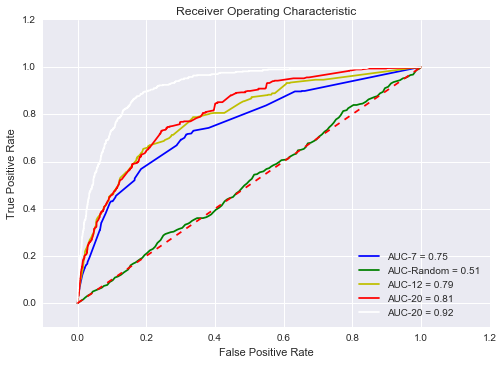

In [76]:
# Plot the actual ROC curve -
# Plot the curve
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC-7 = %0.2f'% roc_auc)
plt.plot(false_positive_ran, true_positive_ran, 'g',
label='AUC-Random = %0.2f'% roc_auc_ran)
plt.plot(false_positive_rate_12, true_positive_rate_12, 'y',
label='AUC-12 = %0.2f'% roc_auc_12)
plt.plot(false_positive_rate_20, true_positive_rate_20, 'r',
label='AUC-20 = %0.2f'% roc_auc_20)
plt.plot(false_positive_21, true_positive_21, 'w',
label='AUC-20 = %0.2f'% roc_auc_21)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

We have generated model with 10,000 records. Now generate the new model with All entries in file. We then divide the file into training data and test data.

### 5.4.7 Real-time full data

In [78]:
# Read the entire csv file into dataframe
main_data = pd.read_csv('en_openfoodfacts_Nov.csv', sep='\t' )

/Users/vingadgil/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,3,5,27,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [79]:
main_data.shape

(107343, 159)

In [ ]:
#train, test = train_test_split(pd_new, test_size = 0.3)
#len(train)
#len(test)

In [80]:
main_new = main_data[['code' , 'product_name' , 'ingredients_text', 'additives','additives_n','main_category_en']]
main_new = main_new[main_new.ingredients_text.notnull()]

In [81]:
len(main_new)

62266

Out of 107343 records we shall consider only 62266 records. Percantage of data used would be around 68%.

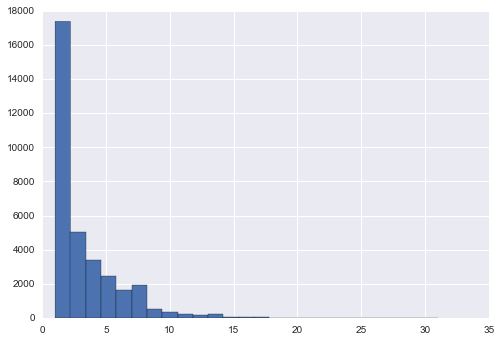

In [82]:
main_additive = main_new[main_new.additives_n > 0]

main_additive.additives_n.hist(bins=25)

In [83]:
main_new['high_add'] = np.where(main_new['additives_n']>4, '1', '0')

len(main_new[main_new['high_add'] == '1'])


7535

In [84]:
main_new.loc['ingredients_text'] = main_new['ingredients_text'].str.upper()

In [85]:
main_new = main_new[main_new.ingredients_text.notnull()]

Creating dummy variables for Ingredients and Categories and text count

In [86]:
# Check if Ingredients have Wheat .

#pd_new['has_wheat'] = pd_new['ingredients_text'].str.match('Wheat|wheat',case = '1', na='0')

wheat = ['Wheat','wheat','Weizen','blé','trigo','WHEAT']
pattern = '|'.join(wheat)
main_new['has_wheat'] = main_new['ingredients_text'].str.contains(pattern)
main_new.has_wheat = main_new.has_wheat.astype(int)


# Check if Ingredients has Salt.

salt = ['Salt','SALT','SAL','SALZ','SEL']
pattern = '|'.join(salt)
main_new['has_salt'] = main_new['ingredients_text'].str.contains(pattern) 
main_new.has_salt = main_new.has_salt.astype(int)

# Check if Ingredients has Sugar

sugar = ['SUGAR','SUCRE','AZÚCAR','ZUCKER','Sugar']
sugar = '|'.join(sugar)
main_new['has_sugar'] = main_new['ingredients_text'].str.contains(sugar)
main_new.has_sugar = main_new.has_sugar.astype(int)

# Check if Ingredients has Chocolate .

chocolate = ['CHOCO','CHOCOLATE','CHOCOLAT','SCHOKOLADE','Chocolate']
chocolate = '|'.join(chocolate)
main_new['has_choco'] = main_new['ingredients_text'].str.contains(chocolate)
main_new.has_choco = main_new.has_choco.astype(int)

# Check if Ingredients has Milk

milk = ['MILK','LECHE','MILCHE','LAIT','Milk']
milk = '|'.join(milk)

main_new['has_milk'] = main_new['ingredients_text'].str.contains(milk)
main_new.has_milk = main_new.has_milk.astype(int)

# Check if Ingredients has Color

color = ['Color','COLOR','FARBE','COULEUR']
color = '|'.join(color)

main_new['has_color'] = main_new['ingredients_text'].str.contains(color)
main_new.has_color = main_new.has_color.astype(int)

# Check if Ingredients has MSG

msg = ['MSG','Msg','MONOSODIUM GLUTAMATE']
msg = '|'.join(msg)

main_new['has_msg'] = main_new['ingredients_text'].str.contains(msg)
main_new.has_msg = main_new.has_msg.astype(int)

# Check if Ingredients has YEAST

yeast = ['Yeast','YEAST','LEVURE','HEFE','LEVADURA']
yeast = '|'.join(yeast)

main_new['has_yeast'] = main_new['ingredients_text'].str.contains(yeast)
main_new.has_yeast = main_new.has_yeast.astype(int)

# Check if Ingredients has cocoa butter

cocoa = ['Cocoa Butter','COCOA BUTTER','COCOA','KAKAOBUTTER','LE BEURRE DE CACAO','CACAO','KAKAO']
cocoa = '|'.join(cocoa)

main_new['has_cocoa'] = main_new['ingredients_text'].str.contains(cocoa)
main_new.has_cocoa = main_new.has_cocoa.astype(int)

# Check if Ingredients has Palm Oil

palm = ['Palm Oil','PALM OIL','PALMÖL','HUILE DE PALME','ACEITE DE PALMA']
palm = '|'.join(palm)

main_new['has_palm'] = main_new['ingredients_text'].str.contains(palm)
main_new.has_palm = main_new.has_palm.astype(int)


In [87]:
# Check if Ingredients has Water

water = ['WATER','water','WASSER','AGUA','EAU']
water = '|'.join(water)

main_new['has_water'] = main_new['ingredients_text'].str.contains(water)
main_new.has_water = main_new.has_water.astype(int)

# Check if Ingredients has Garlic

garlic = ['Garlic','GARLIC','AIL','KNOBLAUCH','AJO']
garlic = '|'.join(garlic)

main_new['has_garlic'] = main_new['ingredients_text'].str.contains(garlic)
main_new.has_garlic = main_new.has_garlic.astype(int)

# Check if Ingredients has Flour

flour = ['Flour','FLOUR','MEHL','FARINE','HARINA']
flour = '|'.join(flour)

main_new['has_flour'] = main_new['ingredients_text'].str.contains(flour)
main_new.has_flour = main_new.has_flour.astype(int)

# Check if Ingredients has Ginger

ginger = ['Ginger','GINGER','GINGREMBRE','INGWER','JINGIBRE']
ginger = '|'.join(ginger)

main_new['has_ginger'] = main_new['ingredients_text'].str.contains(ginger)
main_new.has_ginger = main_new.has_ginger.astype(int)

# Check if Ingredients has honey

honey = ['Honey','HONEY','HONIG','MIEL']
honey = '|'.join(honey)

main_new['has_honey'] = main_new['ingredients_text'].str.contains(honey)
main_new.has_honey = main_new.has_honey.astype(int)

In [88]:
# Create columns on Categories 
main_new['is_plant'] =  np.where(main_new['main_category_en'] == 'Plant-based foods and beverages', '1', '0')
main_new.is_plant = main_new.is_plant.astype(int)

main_new['is_bev'] = np.where(main_new['main_category_en'] == 'Beverages','1','0')
main_new.is_bev = main_new.is_bev.astype(int)

main_new['is_sugar'] = np.where(main_new['main_category_en'] == 'Sugary snacks','1','0')
main_new.is_sugar = main_new.is_sugar.astype(int)

main_new['is_salt'] = np.where(main_new['main_category_en'] == 'Salty snacks','1','0')
main_new.is_salt = main_new.is_salt.astype(int)

main_new['is_dairy'] = np.where(main_new['main_category_en'] == 'Dairies','1','0')
main_new.is_dairy = main_new.is_dairy.astype(int)

main_new['is_meat'] = np.where(main_new['main_category_en'] == 'Meats|Seafood','1','0')
main_new.is_meat = main_new.is_meat.astype(int)

main_new['is_fresh'] = np.where(main_new['main_category_en'] == 'Fresh foods','1','0')
main_new.is_fresh = main_new.is_fresh.astype(int)

main_new['is_break'] = np.where(main_new['main_category_en'] == 'Breakfasts','1','0')
main_new.is_break = main_new.is_break.astype(int)

main_new['is_frozen'] = np.where(main_new['main_category_en'] == 'Frozen foods','1','0')
main_new.is_frozen = main_new.is_frozen.astype(int)

main_new['is_juices'] = np.where(main_new['main_category_en'] == 'Fruit Juices','1','0')
main_new.is_juices = main_new.is_juices.astype(int)



In [89]:
# manually add the intercept
main_new['intercept'] = 1.0
main_new['high_add'] = main_new['high_add'].astype(int)


In [91]:
main_new['text_count'] = main_new['ingredients_text'].apply(lambda x: x.count(',') + 1)

In [92]:
main_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62266 entries, 2 to 107340
Data columns (total 34 columns):
code                62244 non-null object
product_name        61980 non-null object
ingredients_text    62266 non-null object
additives           61742 non-null object
additives_n         62230 non-null float64
main_category_en    60262 non-null object
high_add            62266 non-null int64
has_wheat           62266 non-null int64
has_salt            62266 non-null int64
has_sugar           62266 non-null int64
has_choco           62266 non-null int64
has_milk            62266 non-null int64
has_color           62266 non-null int64
has_msg             62266 non-null int64
has_yeast           62266 non-null int64
has_cocoa           62266 non-null int64
has_palm            62266 non-null int64
has_water           62266 non-null int64
has_garlic          62266 non-null int64
has_flour           62266 non-null int64
has_ginger          62266 non-null int64
has_honey           62266 n

Split the 62000 records into training and test data. We shall consider 70% records as training and 30% test data

In [93]:
train, test = train_test_split(main_new, test_size = 0.3)


In [94]:
print('Training Data -')
print(len(train))
print('Test Data -')
print(len(test))

Training Data -
43586
Test Data -
18680


### 5.4.8 Creating the Logistic Regression model for Training data

In [95]:
train_cols_main = [ 'has_wheat' , 'has_salt' , 'has_sugar', 'has_choco' ,'has_milk','has_cocoa','has_palm',
               'has_water', 'has_garlic','has_flour' ,'has_ginger','has_honey','is_plant','is_bev',
                 'is_sugar','is_salt','is_frozen','is_break','is_dairy','is_fresh','text_count','intercept']


In [96]:
logit_train = sm.Logit(train['high_add'], train[train_cols_main])

# fit the model
result_train = logit_train.fit()
result_train.summary()

Optimization terminated successfully.
         Current function value: 0.264586
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               high_add   No. Observations:                43586
Model:                          Logit   Df Residuals:                    43564
Method:                           MLE   Df Model:                           21
Date:                Wed, 30 Nov 2016   Pseudo R-squ.:                  0.2854
Time:                        16:20:42   Log-Likelihood:                -11532.
converged:                       True   LL-Null:                       -16139.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
has_wheat      0.1120      0.042      2.688      0.007         0.030     0.194
has_salt       0.1955      0.163      1.197      0.231        -0.124     0.516
has_sugar      0.0116      0.157      0.074      0.941        -0.295     0.319
has_choco      0.5955      0.289      2.064      0.039         0.030     1.161
has_milk       0.2396      0.118      2.028      0.043         0.008     0.471
has_cocoa     -1.4897      0.403     -3.695      0.000        -2.280    -0.699
has_palm       0.7817      0.299      2.617      0.009         0.196     1.367
has_water      0.3287      0.127      2.586      0.010         0.080     0.578
has_garlic    -1.4584      0.318     -4.589      0.000        -2.081    -0.835
has_flour     -0.5416      0.216     -2.509      0.012        -0.965    -0.118
has_ginger    -1.2368      0.414     -2.988      0.003        -2.048    -0.425
has_honey     -0.7300      0.488     -1.495      0.135        -1.687     0.227
is_plant      -1.0242      0.064    -16.087      0.000        -1.149    -0.899
is_bev         0.6036      0.066      9.126      0.000         0.474     0.733
is_sugar       0.5353      0.049     10.887      0.000         0.439     0.632
is_salt       -0.2436      0.115     -2.125      0.034        -0.468    -0.019
is_frozen     -1.8819      0.121    -15.591      0.000        -2.118    -1.645
is_break       0.0688      0.155      0.443      0.658        -0.235     0.373
is_dairy       0.1520      0.078      1.939      0.052        -0.002     0.306
is_fresh       0.1098      0.072      1.534      0.125        -0.031     0.250
text_count     0.1344      0.002     63.972      0.000         0.130     0.138
intercept     -3.8284      0.042    -90.286      0.000        -3.911    -3.745
==============================================================================
"""

In [97]:
result_train.conf_int()

,0,1
has_wheat,0.030352,0.193695
has_salt,-0.124498,0.515525
has_sugar,-0.295446,0.318688
has_choco,0.029927,1.161018
has_milk,0.008002,0.471229
has_cocoa,-2.279853,-0.699487
has_palm,0.196222,1.367235
has_water,0.079528,0.577783
has_garlic,-2.081323,-0.835472
has_flour,-0.964683,-0.118439


In [98]:
np.exp(result_train.params)

has_wheat     1.118539
has_salt      1.215935
has_sugar     1.011689
has_choco     1.813889
has_milk      1.270760
has_cocoa     0.225447
has_palm      2.185246
has_water     1.389100
has_garlic    0.232609
has_flour     0.581839
has_ginger    0.290311
has_honey     0.481885
is_plant      0.359086
is_bev        1.828680
is_sugar      1.707938
is_salt       0.783830
is_frozen     0.152307
is_break      1.071179
is_dairy      1.164114
is_fresh      1.116102
text_count    1.143804
intercept     0.021745
dtype: float64

In [99]:
# Predict Y using the logit function.
train['ypred'] = result_train.predict(train[train_cols_main])

train['ypred_class'] = np.where(train['ypred']>0.12, '1', '0')
train['ypred_class'] = train['ypred_class'].astype(int)

/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [100]:
conf_mat_train = ConfusionMatrix(train['high_add'], train['ypred_class'])
#print("Confusion matrix:\n%s" % conf_mat_train)

conf_mat_train.print_stats()

Confusion Matrix:

Predicted      0      1  __all__
Actual                          
0          30684   7598    38282
1           1085   4219     5304
__all__    31769  11817    43586


Overall Statistics:

Accuracy: 0.800784655623
95% CI: (0.79700352660524232, 0.80452567712587897)
No Information Rate: ToDo
P-Value [Acc > NIR]: 1.44811827917e-266
Kappa: 0.390451416009
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                        0          1
Population                                 43586      43586
P: Condition positive                      38282       5304
N: Condition negative                       5304      38282
Test outcome positive                      31769      11817
Test outcome negative                      11817      31769
TP: True Positive                          30684       4219
TN: True Negative                           4219      30684
FP: False Positive                          1085       7598
FN: False Negative                     

In [101]:
# Create ROC curve for Training model
false_positive_train, true_positive_train, thresholds = roc_curve(train['high_add'], train['ypred'])
roc_auc_train = auc(false_positive_train, true_positive_train)
roc_auc_train

0.87595991963032471

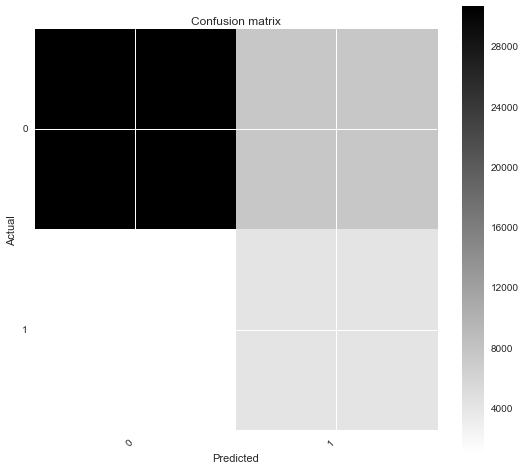

In [108]:
conf_mat_train.plot()
plt.show()

### 5.4.9 Creating the Logistic Regression model for test Data

In [102]:
logit_test = sm.Logit(test['high_add'], test[train_cols_main])

# fit the model
result_test = logit_test.fit()
result_test.summary()

Optimization terminated successfully.
         Current function value: 0.264342
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               high_add   No. Observations:                18680
Model:                          Logit   Df Residuals:                    18658
Method:                           MLE   Df Model:                           21
Date:                Wed, 30 Nov 2016   Pseudo R-squ.:                  0.2773
Time:                        16:23:00   Log-Likelihood:                -4937.9
converged:                       True   LL-Null:                       -6833.0
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
has_wheat      0.0741      0.064      1.162      0.245        -0.051     0.199
has_salt      -0.0357      0.252     -0.142      0.887        -0.529     0.458
has_sugar     -0.0247      0.248     -0.100      0.921        -0.511     0.461
has_choco     -0.8153      0.522     -1.560      0.119        -1.839     0.209
has_milk       0.5101      0.174      2.934      0.003         0.169     0.851
has_cocoa     -0.2740      0.563     -0.487      0.626        -1.377     0.829
has_palm       0.6885      0.490      1.406      0.160        -0.271     1.648
has_water      0.2099      0.213      0.984      0.325        -0.208     0.628
has_garlic    -1.7498      0.510     -3.428      0.001        -2.750    -0.749
has_flour     -0.7712      0.348     -2.218      0.027        -1.453    -0.090
has_ginger    -1.0195      0.663     -1.537      0.124        -2.320     0.281
has_honey     -0.6689      0.914     -0.731      0.465        -2.461     1.123
is_plant      -1.3168      0.105    -12.557      0.000        -1.522    -1.111
is_bev         0.5794      0.100      5.820      0.000         0.384     0.774
is_sugar       0.4939      0.074      6.658      0.000         0.348     0.639
is_salt        0.0339      0.162      0.209      0.834        -0.284     0.351
is_frozen     -1.9700      0.196    -10.059      0.000        -2.354    -1.586
is_break      -0.6332      0.308     -2.055      0.040        -1.237    -0.029
is_dairy       0.1087      0.117      0.928      0.353        -0.121     0.338
is_fresh      -0.0074      0.110     -0.067      0.947        -0.224     0.209
text_count     0.1358      0.003     41.773      0.000         0.129     0.142
intercept     -3.7834      0.064    -59.006      0.000        -3.909    -3.658
==============================================================================
"""

In [103]:
result_test.conf_int()

,0,1
has_wheat,-0.050927,0.199204
has_salt,-0.528939,0.457581
has_sugar,-0.510689,0.461210
has_choco,-1.839274,0.208733
has_milk,0.169363,0.850765
has_cocoa,-1.377057,0.829091
has_palm,-0.271331,1.648254
has_water,-0.208393,0.628186
has_garlic,-2.750203,-0.749310
has_flour,-1.452829,-0.089580


In [104]:
np.exp(result_test.params)

has_wheat     1.076956
has_salt      0.964950
has_sugar     0.975564
has_choco     0.442520
has_milk      1.665398
has_cocoa     0.760345
has_palm      1.990651
has_water     1.233551
has_garlic    0.173816
has_flour     0.462456
has_ginger    0.360777
has_honey     0.512284
is_plant      0.267987
is_bev        1.784896
is_sugar      1.638691
is_salt       1.034432
is_frozen     0.139458
is_break      0.530895
is_dairy      1.114876
is_fresh      0.992620
text_count    1.145423
intercept     0.022746
dtype: float64

In [105]:
# Predict Y using the logit function.
test['ypred'] = result_test.predict(test[train_cols_main])

test['ypred_class'] = np.where(test['ypred']>0.12, '1', '0')
test['ypred_class'] = test['ypred_class'].astype(int)

/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vingadgil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [106]:
conf_mat_test = ConfusionMatrix(test['high_add'], test['ypred_class'])
#print("Confusion matrix:\n%s" % conf_mat_test)

conf_mat_test.print_stats()

Confusion Matrix:

Predicted      0     1  __all__
Actual                         
0          13163  3286    16449
1            456  1775     2231
__all__    13619  5061    18680


Overall Statistics:

Accuracy: 0.799678800857
95% CI: (0.79386599233941002, 0.80539817789631185)
No Information Rate: ToDo
P-Value [Acc > NIR]: 2.12685413163e-111
Kappa: 0.384853496598
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                        0          1
Population                                 18680      18680
P: Condition positive                      16449       2231
N: Condition negative                       2231      16449
Test outcome positive                      13619       5061
Test outcome negative                       5061      13619
TP: True Positive                          13163       1775
TN: True Negative                           1775      13163
FP: False Positive                           456       3286
FN: False Negative                          

In [107]:
# Create ROC curve for Test model
false_positive_test, true_positive_test, thresholds = roc_curve(test['high_add'], test['ypred'])
roc_auc_test = auc(false_positive_test, true_positive_test)
roc_auc_test

0.87226757881055217

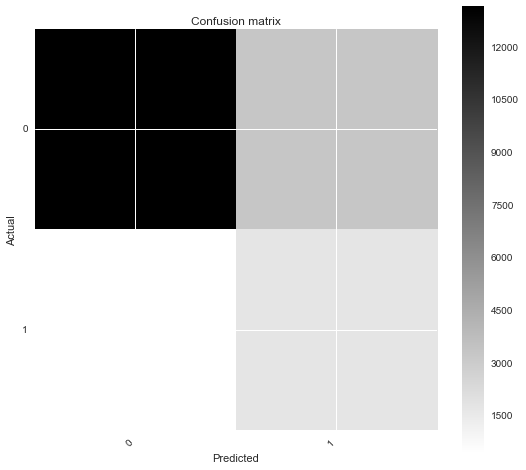

In [109]:
conf_mat_test.plot()
plt.show()

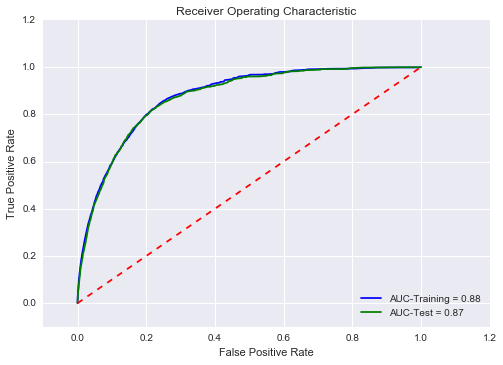

In [110]:
# Plot the actual ROC curve -
# Plot the curve
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_train, true_positive_train, 'b',
label='AUC-Training = %0.2f'% roc_auc_train)
plt.plot(false_positive_test, true_positive_test, 'g',
label='AUC-Test = %0.2f'% roc_auc_test)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()